In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Copiar para a pasta do Colab
#!cp -r /content/drive/MyDrive/2025.1/Projeto-Itau/CELEB-DF /content/celeb-df

In [2]:
# Instalar bibliotecas necessárias
#!pip install transformers torch torchvision opencv-python ffmpeg-python
import torch
import cv2
import numpy as np
import ffmpeg
from transformers import pipeline, AutoImageProcessor, AutoModelForVideoClassification

2025-03-21 23:29:55.273108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 23:29:55.403047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 23:29:55.434404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 23:29:55.700450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-21 23:29:57.383248: W tensorflow/compiler/tf2

In [3]:
# Função para extrair e redimensionar frames corretamente
def extract_and_resize_frames(video_path, num_frames=16, size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_idxs = np.linspace(0, total_frames - 1, num_frames, dtype=int)  # Pega 16 frames uniformemente distribuídos

    for idx in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if idx in frame_idxs:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Converter para RGB
            frame = cv2.resize(frame, size)  # Redimensionar para (224,224)
            frames.append(frame)

    cap.release()

    # Garantir exatamente 16 frames
    while len(frames) < num_frames:  # Se houver menos de 16 frames, repetir o último frame
        frames.append(frames[-1])

    return frames  # Retornar como lista de arrays NumPy

In [4]:
# Função para classificar um vídeo
def classify_video(video_path, processor, model, num_frames=32):    # Extrair e processar os frames corretamente
    frames = extract_and_resize_frames(video_path, num_frames=num_frames, size=(224, 224))
    inputs = processor(frames, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()  # 1 se FAKE, 0 se REAL
    return prediction

In [9]:
import os

# Listar vídeos nos diretórios
fake_dir = '/home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake'
real_dir = '/home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real'
fake_videos = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
real_videos = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(('.mp4', '.avi', '.mov'))]

In [10]:
# Carregar modelo e processador
processor = AutoImageProcessor.from_pretrained("shylhy/videomae-large-finetuned-deepfake-subset")
model = AutoModelForVideoClassification.from_pretrained("shylhy/videomae-large-finetuned-deepfake-subset")

In [19]:
# Resultados
results = []
correct = 0
total = 0

In [21]:
# Classificar vídeos falsos (esperado: 1)
for video_path in fake_videos:
    print(f"Total: {total} Corretos: {correct} VideoPath: {video_path}")
    prediction = classify_video(video_path, processor, model, num_frames=32)  # Ajuste num_frames se necessário
    expected = 1  # FAKE
    is_correct = prediction == expected
    results.append({
        'video': os.path.basename(video_path),
        'predicted': 'FAKE' if prediction == 1 else 'REAL',
        'expected': 'FAKE',
        'correct': is_correct
    })
    correct += is_correct
    total += 1

Total: 50 Corretos: 5 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake/id0_id2_0002.mp4
Total: 51 Corretos: 6 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake/id0_id4_0002.mp4
Total: 52 Corretos: 7 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake/id0_id9_0001.mp4
Total: 53 Corretos: 8 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake/id0_id3_0003.mp4
Total: 54 Corretos: 8 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake/id0_id1_0001.mp4
Total: 55 Corretos: 9 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake/id0_id3_0008.mp4
Total: 56 Corretos: 10 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake/id0_id3_0000.mp4
Total: 57 Corretos: 11 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake/id0_id6_0002.mp4
Total: 58 Corretos: 12 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Fake/id0_id3_0001.mp4
Total: 59 Corretos: 13 Vi

In [20]:
# Classificar vídeos reais (esperado: 0)
for video_path in real_videos:
    print(f"Total: {total} Corretos: {correct} VideoPath: {video_path}")
    prediction = classify_video(video_path, processor, model, num_frames=32)  # Ajuste num_frames se necessário
    expected = 0  # REAL
    is_correct = prediction == expected
    results.append({
        'video': os.path.basename(video_path),
        'predicted': 'FAKE' if prediction == 1 else 'REAL',
        'expected': 'REAL',
        'correct': is_correct
    })
    correct += is_correct
    total += 1

Total: 0 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real/id4_0006.mp4
Total: 1 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real/id1_0005.mp4
Total: 2 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real/id2_0006.mp4
Total: 3 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real/id3_0006.mp4
Total: 4 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real/id3_0003.mp4
Total: 5 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real/id4_0003.mp4
Total: 6 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real/id0_0000.mp4
Total: 7 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real/id2_0009.mp4
Total: 8 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/dataset/celeb-df/Real/id1_0008.mp4
Total: 9 Corretos: 0 VideoPath: /home/flavio/Dev/Deepfake-Detection/datas

In [22]:
# Exibir resultados
print("\nResultados da classificação:")
print(f"{'Vídeo':<30} {'Predito':<10} {'Esperado':<10} {'Correto':<10}")
print("-" * 60)
for result in results:
    print(f"{result['video']:<30} {result['predicted']:<10} {result['expected']:<10} {str(result['correct']):<10}")


Resultados da classificação:
Vídeo                          Predito    Esperado   Correto   
------------------------------------------------------------
id4_0006.mp4                   FAKE       REAL       False     
id1_0005.mp4                   FAKE       REAL       False     
id2_0006.mp4                   FAKE       REAL       False     
id3_0006.mp4                   FAKE       REAL       False     
id3_0003.mp4                   FAKE       REAL       False     
id4_0003.mp4                   FAKE       REAL       False     
id0_0000.mp4                   FAKE       REAL       False     
id2_0009.mp4                   FAKE       REAL       False     
id1_0008.mp4                   FAKE       REAL       False     
id3_0001.mp4                   FAKE       REAL       False     
id1_0000.mp4                   FAKE       REAL       False     
id2_0005.mp4                   FAKE       REAL       False     
id0_0002.mp4                   FAKE       REAL       False     
id0_0005.mp4 

In [23]:
# Calcular e exibir acurácia
accuracy = correct / total if total > 0 else 0
print(f"\nAcurácia: {accuracy * 100:.2f}% ({correct}/{total})")


Acurácia: 46.00% (46/100)



Matriz de Confusão:
[[41  9]
 [45  5]]


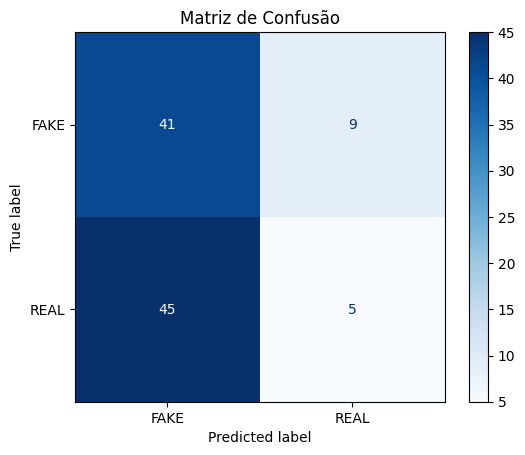

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Gerar dados para matriz de confusão
y_true = [1 if result['expected'] == 'FAKE' else 0 for result in results]
y_pred = [1 if result['predicted'] == 'FAKE' else 0 for result in results]

# Criar matriz de confusão
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

print("\nMatriz de Confusão:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE", "REAL"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()